In [1]:
import wrds

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
#This function gets vw returns for given alphabet
def getReturns(alph):
    db = wrds.Connection(wrds_username='ashhersh')
    Astocks=db.raw_sql("""select b.htick,a.date,a.ret, abs(a.prc*a.shrout) as cap
    from crsp.msf as a left join crsp.msfhdr as b
    on a.permno=b.permno
    where a.date>='01/01/2014'
    and b.hcomnam like(\'"""+alph+"""%%\')
    and b.htick is not null
    and a.ret is not null""")

    Astocks=Astocks[pd.notnull(Astocks['ret'])]
    arrays = [Astocks.htick.values,Astocks.date.values]
    index = pd.MultiIndex.from_arrays(arrays, names=('Ticker', 'Date'))
    data = pd.DataFrame({'Return' : Astocks.ret.values , 'Cap' : Astocks.cap.values}, index=index)
    Astocks['date']=pd.to_datetime(Astocks['date'])

    data1 = data.pivot_table(index='Ticker', columns='Date', values='Return')
    data2 = data1.dropna()
    retdf = data2.transpose()
    
    dfCap = data.pivot_table(index='Ticker', columns='Date', values='Cap').dropna()
    
    pfret = pd.DataFrame(index=dfCap.columns, columns=['VW Returns'])
    
    for i in range(len(dfCap.columns)):
        wl = dfCap.iloc[:,i]/dfCap.iloc[:,i].sum()

        rl = data2.iloc[:,i]

        ret = (rl*wl).sum()

        pfret.loc[i:] = ret
    
    pfret
    
    db.close()
    return pfret;

def sillyPortfolio(alph1,alph2):
    pfret = getReturns(alph1)-getReturns(alph2)
    pfret['cumret'] = np.cumprod(1 + pfret['VW Returns'].values)*1e6
    plt.figure(figsize=(14,8))
    plt.xlabel('Year')
    plt.ylabel('Portfolio Returns')
    plt.plot(pfret.index,pfret['cumret'])
    plt.show()
    pfret.describe
    return pfret;

Loading library list...
Done
Loading library list...
Done


C:\Users\AMMAR\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


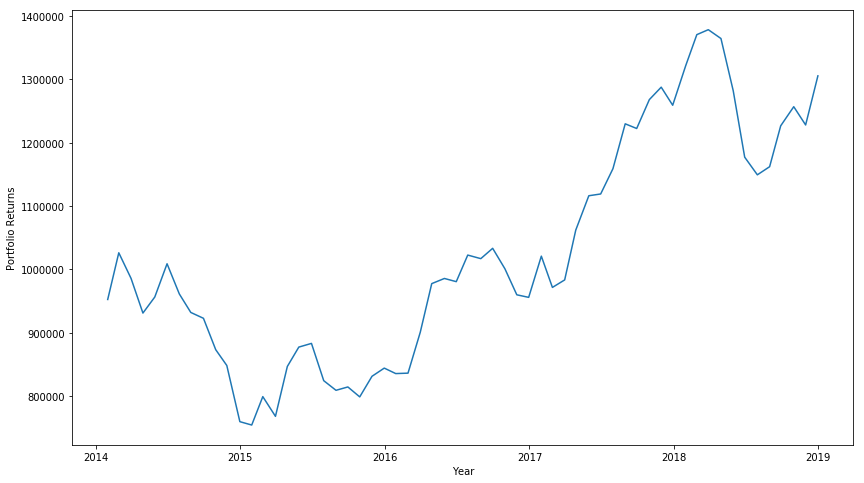

,VW Returns,cumret
count,60.000000,6.000000e+01
unique,60.000000,6.000000e+01
top,-0.066608,1.268223e+06
freq,1.000000,1.000000e+00


In [4]:
#this function goes long on first alphabet and short on second and gives net portfolio returns
sillyPortfolio('Y','K').describe()